### Network Model of the NYC Subway Network with IBX Stations

In [1]:
#add necessary libraries
import networkx as nx #library supporting networks
import matplotlib.pyplot as plt #plotting
import pandas as pd
import numpy as np
import scipy.stats as stat
#make sure plots are embedded into the notebook
%matplotlib inline 
#pd.set_option('max_columns',None)

In [31]:
#station list, with IBX stations encoded
Stations = pd.read_csv('Stations_wIBX.csv', index_col=0, header=0)
Stations

,name,id,boro,lat,long,lines
0,Greenpoint Av,G26,Bk,40.731352,-73.954449,G
1,21 St,G24,Q,40.744065,-73.949724,G
2,Court Sq,G22,Q,40.746554,-73.943832,G
3,36 St,G20,Q,40.752039,-73.928781,M R
4,Queens Plaza,G21,Q,40.748973,-73.937243,E M R
...,...,...,...,...,...,...
502,Rockaway Pkwy,X8,Bk,40.651228,-73.908889,IBX
503,Myrtle Av,X12,Q,40.700453,-73.894421,IBX
504,74 St,X14,Q,40.733015,-73.887789,IBX
505,Queens Blvd,X15,Q,40.738486,-73.890111,IBX


In [32]:
#filter out Staten Island, as its rail network is unconnected with the rest of the network
Stations = Stations.loc[Stations['boro'] != 'SI']

In [33]:
#Split the lines into multiple columns
Stations = Stations.join(Stations['lines'].str.split(' ', expand=True)).rename({0:'line_1',1:'line_2',2:'line_3',3:'line_4'}, axis=1)
Stations

,name,id,boro,lat,long,lines,line_1,line_2,line_3,line_4
0,Greenpoint Av,G26,Bk,40.731352,-73.954449,G,G,None,None,None
1,21 St,G24,Q,40.744065,-73.949724,G,G,None,None,None
2,Court Sq,G22,Q,40.746554,-73.943832,G,G,None,None,None
3,36 St,G20,Q,40.752039,-73.928781,M R,M,R,None,None
4,Queens Plaza,G21,Q,40.748973,-73.937243,E M R,E,M,R,None
...,...,...,...,...,...,...,...,...,...,...
502,Rockaway Pkwy,X8,Bk,40.651228,-73.908889,IBX,IBX,None,None,None
503,Myrtle Av,X12,Q,40.700453,-73.894421,IBX,IBX,None,None,None
504,74 St,X14,Q,40.733015,-73.887789,IBX,IBX,None,None,None
505,Queens Blvd,X15,Q,40.738486,-73.890111,IBX,IBX,None,None,None


In [34]:
#For stations with more than 1 line, unpivot to create new rows.
stli = pd.wide_to_long(Stations, stubnames='line_',i='id',j='station_line').sort_index(level=0)
stli.dropna(inplace=True)
stli.reset_index(inplace=True)
stli.rename({'id':'station_id'},axis=1,inplace=True)
stli

,station_id,station_line,lat,long,name,lines,boro,line_
0,101,1,40.889248,-73.898583,Van Cortlandt Park - 242 St,1,Bx,1
1,103,1,40.884667,-73.900870,238 St,1,Bx,1
2,104,1,40.878856,-73.904834,231 St,1,Bx,1
3,106,1,40.874561,-73.909831,Marble Hill - 225 St,1,M,1
4,107,1,40.869444,-73.915279,215 St,1,M,1
...,...,...,...,...,...,...,...,...
760,X16,1,40.746530,-73.894401,Jackson Hts,IBX,Q,IBX
761,X5,1,40.630902,-73.947985,Brooklyn College,IBX,Bk,IBX
762,X6,1,40.637348,-73.928442,Farragut Rd - Utica Av,IBX,Bk,IBX
763,X7,1,40.643589,-73.919353,Ralph Av,IBX,Bk,IBX


In [36]:
#each station-line has 2 platforms for trains going in both directions, so we can duplicate the table
pfs = pd.concat([stli]*2)
#create a new columns to distinguish north and south-bound trains, add South designation to half of the rows
pfs['dir'] = 'N'
pfs.iloc[:stli.shape[0],8] = 'S'
pfs

,station_id,station_line,lat,long,name,lines,boro,line_,dir
0,101,1,40.889248,-73.898583,Van Cortlandt Park - 242 St,1,Bx,1,S
1,103,1,40.884667,-73.900870,238 St,1,Bx,1,S
2,104,1,40.878856,-73.904834,231 St,1,Bx,1,S
3,106,1,40.874561,-73.909831,Marble Hill - 225 St,1,M,1,S
4,107,1,40.869444,-73.915279,215 St,1,M,1,S
...,...,...,...,...,...,...,...,...,...
760,X16,1,40.746530,-73.894401,Jackson Hts,IBX,Q,IBX,N
761,X5,1,40.630902,-73.947985,Brooklyn College,IBX,Bk,IBX,N
762,X6,1,40.637348,-73.928442,Farragut Rd - Utica Av,IBX,Bk,IBX,N
763,X7,1,40.643589,-73.919353,Ralph Av,IBX,Bk,IBX,N


In [37]:
#create platform_id field based on station_id + line + dir
pfs['pf_id'] = pfs['station_id'] + '-' + pfs['line_'] + '-' + pfs['dir']
pfs

,station_id,station_line,lat,long,name,lines,boro,line_,dir,pf_id
0,101,1,40.889248,-73.898583,Van Cortlandt Park - 242 St,1,Bx,1,S,101-1-S
1,103,1,40.884667,-73.900870,238 St,1,Bx,1,S,103-1-S
2,104,1,40.878856,-73.904834,231 St,1,Bx,1,S,104-1-S
3,106,1,40.874561,-73.909831,Marble Hill - 225 St,1,M,1,S,106-1-S
4,107,1,40.869444,-73.915279,215 St,1,M,1,S,107-1-S
...,...,...,...,...,...,...,...,...,...,...
760,X16,1,40.746530,-73.894401,Jackson Hts,IBX,Q,IBX,N,X16-IBX-N
761,X5,1,40.630902,-73.947985,Brooklyn College,IBX,Bk,IBX,N,X5-IBX-N
762,X6,1,40.637348,-73.928442,Farragut Rd - Utica Av,IBX,Bk,IBX,N,X6-IBX-N
763,X7,1,40.643589,-73.919353,Ralph Av,IBX,Bk,IBX,N,X7-IBX-N


In [38]:
#let's change the lat-long slightly for the platforms so they aren't totally on top of each other. this is not meant to be geographically accurate!
#offset the 1st platform from the station by .0006 degrees lat, which is about 200 feet north
pfs.loc[pfs.station_line ==1,'lat'] = pfs.loc[pfs.station_line ==1,'lat'] + .0006
pfs.loc[pfs.station_line ==2,'long'] = pfs.loc[pfs.station_line ==2,'long'] + .0006 #offset to east
pfs.loc[pfs.station_line ==3,'lat'] = pfs.loc[pfs.station_line ==3,'lat'] - .0006  #offset to south
pfs.loc[pfs.station_line ==4,'long'] = pfs.loc[pfs.station_line ==4,'long'] - .0006 #offset to west

#and let's offset the north platforms from the south by adding .0001 degrees lat or ~35 feet north
pfs.loc[pfs.dir =='N','lat'] = pfs.loc[pfs.dir =='N','lat'] + .0006


In [39]:
#finally, let's concatenate the stations to the platforms
Stations.rename({'id':'station_id','lines':'line_'},axis=1,inplace=True)
Stations.drop(['line_1','line_2','line_3','line_4'],axis = 1,inplace=True)
Stations[['pf_id','dir','station_line']] = 'station'
nodes = pd.concat([pfs,Stations])

In [40]:
nodes['node_id'] = np.where(nodes['pf_id'] != 'station',nodes['pf_id'],nodes['station_id'])
nodes.reset_index(inplace=True,drop=True)
nodes

,station_id,station_line,lat,long,name,lines,boro,line_,dir,pf_id,node_id
0,101,1,40.889848,-73.898583,Van Cortlandt Park - 242 St,1,Bx,1,S,101-1-S,101-1-S
1,103,1,40.885267,-73.900870,238 St,1,Bx,1,S,103-1-S,103-1-S
2,104,1,40.879456,-73.904834,231 St,1,Bx,1,S,104-1-S,104-1-S
3,106,1,40.875161,-73.909831,Marble Hill - 225 St,1,M,1,S,106-1-S,106-1-S
4,107,1,40.870044,-73.915279,215 St,1,M,1,S,107-1-S,107-1-S
...,...,...,...,...,...,...,...,...,...,...,...
2009,X8,station,40.651228,-73.908889,Rockaway Pkwy,NaN,Bk,IBX,station,station,X8
2010,X12,station,40.700453,-73.894421,Myrtle Av,NaN,Q,IBX,station,station,X12
2011,X14,station,40.733015,-73.887789,74 St,NaN,Q,IBX,station,station,X14
2012,X15,station,40.738486,-73.890111,Queens Blvd,NaN,Q,IBX,station,station,X15


In [41]:
nodes.iloc[100:140]

,station_id,station_line,lat,long,name,lines,boro,line_,dir,pf_id,node_id
100,229,2,40.709416,-74.005971,Fulton St,2 3,M,3,S,229-3-S,229-3-S
101,230,1,40.707421,-74.009100,Wall St,2 3,M,2,S,230-2-S,230-2-S
102,230,2,40.706821,-74.008500,Wall St,2 3,M,3,S,230-3-S,230-3-S
103,231,1,40.698066,-73.993086,Clark St,2 3,Bk,2,S,231-2-S,231-2-S
104,231,2,40.697466,-73.992486,Clark St,2 3,Bk,3,S,231-3-S,231-3-S
105,232,1,40.693819,-73.989998,Borough Hall,2 3,Bk,2,S,232-2-S,232-2-S
106,232,2,40.693219,-73.989398,Borough Hall,2 3,Bk,3,S,232-3-S,232-3-S
107,233,1,40.691145,-73.985065,Hoyt St,2 3,Bk,2,S,233-2-S,233-2-S
108,233,2,40.690545,-73.984465,Hoyt St,2 3,Bk,3,S,233-3-S,233-3-S
109,234,1,40.688846,-73.980492,Nevins St,2 3 4 5,Bk,2,S,234-2-S,234-2-S


In [ ]:
#next step is edges. the edge list actually shows multiple edges for each line and direction. for example, station 230 (Wall Street) 
# and station 231 (Clark Street) are already connected by 4 edges: the 2 and 3 trains, northbound and southbound. However, because the stations
# are represented as single nodes, these 4 edges are indistinguishable from one another, and networkx only uses 1 of them anyway.

#so for each of these existing edges, we need to reset the origin and destination based on the platform_id. In the example above, we need to
# end up with the following edges:
# 230-2-S --> 231-2-S
# 230-3-S --> 231-3-S
# 231-2-N --> 230-2-N
# 231-3-N --> 230-3-N

#actually, we don't need this to be a directed graph, so don't worry if northbound edges are going south.
# But it is important that only edges with the same line and direction are connected. So we can't have a southbound train going to a northbound
# platform, and we can't have a 2 train going to a 3 platform (even though in actuality they do share a platfom)

#So basically, for each unique origin and destination in the edge list, we need to look up the lines that are serving both of those stations.
# If the stations have line(s) in common, we draw an edge between the corresponding platforms in both directions

# I think the easiest way to do this in practice is to add a bunch of columns to the edge list, for each of the ~31 subway lines
# If both the origin and destination of the edge contain the same line, mark that as a 1, otherwise if one/both doesn't have that line mark 0

#After all of this, don't forget to add edges between the stations and platforms!


In [42]:
#connection list, with IBX connections encoded
Links = pd.read_csv('Links_wIBX.csv', index_col=0, header=0)
Links

,origin,dest
0,G26,G24
1,G26,G28
2,G24,G26
3,G24,G22
4,G22,G24
...,...,...
1862,M01,X14
1863,X14,X15
1864,X15,X16
1865,X16,710


In [43]:
#the repeated edges are of no use to us, so let's get unique edges.
uLinks = Links.drop_duplicates().reset_index()
uLinks.drop('index',axis=1,inplace=True)
uLinks.shape

(1227, 2)

In [44]:
#get the links for the Prospect Park Shuttle
S_links = uLinks.loc[(uLinks['origin'].isin(['S01', 'S03', 'S04'])) | \
(uLinks['dest'].isin(['S01', 'S03', 'S04']))]

S_links

,origin,dest
154,A45,S01
237,239,S04
1077,D26,S04
1107,S01,S03
1108,S01,A45
1109,S03,S01
1110,S03,S04
1111,S04,S03
1112,S04,239
1113,S04,D26


In [45]:
#drop links from Staten Island, concatenate Shuttle links back in (since they get dropped here)
uLinks = uLinks.loc[(~uLinks['origin'].str.startswith('S')) | (~uLinks['dest'].str.startswith('S'))]

uLinks = pd.concat([uLinks, S_links], ignore_index=True)
uLinks

,origin,dest
0,G26,G24
1,G26,G28
2,G24,G26
3,G24,G22
4,G22,G24
...,...,...
1188,S03,S01
1189,S03,S04
1190,S04,S03
1191,S04,239


In [46]:
#Also, we don't need a directed graph because we will incorporate that logic into the platforms, i.e. only northbound platforms can have an edge, but the direction of that edge
#isn't important. If the northbound edges are actually going south geographically, it doesn't make a difference. So let's remove duplicate edges that are A-->B and B-->A
uuLinks = uLinks[pd.DataFrame(np.sort(uLinks[['origin','dest']].values,1)).duplicated()].sort_values('origin')
uuLinks.reset_index(inplace=True)
uuLinks

,index,origin,dest
0,127,101,103
1,133,104,106
2,132,104,103
3,130,107,108
4,131,107,106
...,...,...,...
584,1190,S04,S03
585,1068,S04,239
586,1191,S04,239
587,1069,S04,D26


In [49]:
d = pd.DataFrame(np.zeros((uuLinks.shape[0], pfs.line_.nunique())))
d.columns = pfs.line_.unique()
uuLinks = pd.concat([uuLinks,d],axis=1)
uuLinks

,index,origin,dest,1,2,3,5,4,6,7,...,G,Q,M,IBX,N,J,Z,R,L,W
0,127,101,103,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,133,104,106,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,132,104,103,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,130,107,108,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,131,107,106,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
584,1190,S04,S03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
585,1068,S04,239,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
586,1191,S04,239,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
587,1069,S04,D26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [50]:
i = 0
for o, d in zip(uuLinks.origin, uuLinks.dest):
    o_lines = Stations.loc[Stations['station_id'] == o,'line_'].str.split(' ').values[0]
    d_lines = Stations.loc[Stations['station_id'] == d,'line_'].str.split(' ').values[0]
    common = [value for value in o_lines if value in d_lines]
    for lc in common:
        uuLinks.loc[uuLinks.index[i],lc] =1
    i +=1

In [51]:
uuLinks

,index,origin,dest,1,2,3,5,4,6,7,...,G,Q,M,IBX,N,J,Z,R,L,W
0,127,101,103,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,133,104,106,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,132,104,103,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,130,107,108,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,131,107,106,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
584,1190,S04,S03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
585,1068,S04,239,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
586,1191,S04,239,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
587,1069,S04,D26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [52]:
#I got the output I wanted, but it's tricky because some stations are actually represented as multiple nodes, e.g. Union Sq vs Union Sq - 14 St.
# There are actually quite a few of these (146 edges). I will draw edges between the stations themselves, not the platforms. So basically I can leave them as-is.
# everything else is a platform-platform edge (until we draw station-platform edges)

uuLinks['total_edges'] = 0
for i in uuLinks.index:
    uuLinks.loc[i, 'total_edges'] = uuLinks.loc[i, '1':'total_edges'].sum()

pfs_edges = uuLinks[uuLinks['total_edges'] > 0]
ss_edges = uuLinks[uuLinks['total_edges'] == 0]


In [53]:
pfs_edges.head()

,index,origin,dest,1,2,3,5,4,6,7,...,Q,M,IBX,N,J,Z,R,L,W,total_edges
0,127,101,103,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,133,104,106,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,132,104,103,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,130,107,108,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,131,107,106,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [54]:
#each platform edge needs to be multiplied by the total_edges. Let's use wide to long, then filter out all of the 0 edges
pfs_edges_tr = pfs_edges.drop(['total_edges','index'],axis=1).melt(id_vars=['origin','dest'])
pfs_edges_tr = pfs_edges_tr[pfs_edges_tr['value'] >0]
pfs_edges_tr = pfs_edges_tr.rename({'variable':'line'},axis=1).drop('value',axis=1)
pfs_edges_tr

,origin,dest,line
0,101,103,1
1,104,106,1
2,104,103,1
3,107,108,1
4,107,106,1
...,...,...,...
12212,R22,R23,W
12213,R23,R24,W
12214,R24,R25,W
12215,R25,R26,W


In [55]:
#rename the origin and destination based on the line and direction.
pfs_edges_tr['origin_stli'] = pfs_edges_tr['origin'] + '-' + pfs_edges_tr['line']
pfs_edges_tr['dest_stli'] = pfs_edges_tr['dest'] + '-' + pfs_edges_tr['line']

#double the dataframe for northbound and southbound platforms
pfs_edges_tr = pd.concat([pfs_edges_tr]*2)
pfs_edges_tr['dir'] = 'N'
pfs_edges_tr.iloc[:int(pfs_edges_tr.shape[0]/2), 5] = 'S'
pfs_edges_tr

,origin,dest,line,origin_stli,dest_stli,dir
0,101,103,1,101-1,103-1,S
1,104,106,1,104-1,106-1,S
2,104,103,1,104-1,103-1,S
3,107,108,1,107-1,108-1,S
4,107,106,1,107-1,106-1,S
...,...,...,...,...,...,...
12212,R22,R23,W,R22-W,R23-W,N
12213,R23,R24,W,R23-W,R24-W,N
12214,R24,R25,W,R24-W,R25-W,N
12215,R25,R26,W,R25-W,R26-W,N


In [56]:
pfs_edges_tr['origin'] = pfs_edges_tr['origin_stli'] + '-' + pfs_edges_tr['dir']
pfs_edges_tr['dest'] = pfs_edges_tr['dest_stli'] + '-' + pfs_edges_tr['dir']
pfs_edges_tr.drop(['origin_stli','dest_stli','dir'],axis=1,inplace=True)
pfs_edges_tr.reset_index(inplace=True, drop=True)
pfs_edges_tr

,origin,dest,line
0,101-1-S,103-1-S,1
1,104-1-S,106-1-S,1
2,104-1-S,103-1-S,1
3,107-1-S,108-1-S,1
4,107-1-S,106-1-S,1
...,...,...,...
1505,R22-W-N,R23-W-N,W
1506,R23-W-N,R24-W-N,W
1507,R24-W-N,R25-W-N,W
1508,R25-W-N,R26-W-N,W


In [57]:
#we now have all station-to-station edges and platform-to-platform edges. Now let's make a final set of edges between the station and its platforms.
#We can just use the platforms dataframe to get the platform ID and the station ID the platform belongs to
stpf_edges = pfs[['station_id','pf_id','line_']]
stpf_edges.rename({'station_id':'origin','pf_id':'dest','line_':'line'},axis=1,inplace=True)
stpf_edges

C:\Users\Rohan\AppData\Local\Temp\ipykernel_2508\2067928534.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stpf_edges.rename({'station_id':'origin','pf_id':'dest','line_':'line'},axis=1,inplace=True)


,origin,dest,line
0,101,101-1-S,1
1,103,103-1-S,1
2,104,104-1-S,1
3,106,106-1-S,1
4,107,107-1-S,1
...,...,...,...
760,X16,X16-IBX-N,IBX
761,X5,X5-IBX-N,IBX
762,X6,X6-IBX-N,IBX
763,X7,X7-IBX-N,IBX


In [58]:
#remove unnecessary columns from the station-to-station edge dataframe
ss_edges

,index,origin,dest,1,2,3,5,4,6,7,...,Q,M,IBX,N,J,Z,R,L,W,total_edges
8,921,112,A09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
27,601,127,902,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
63,1059,222,415,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
71,1048,228,A36,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
73,1046,228,E01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
582,1187,S01,A45,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
585,1068,S04,239,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
586,1191,S04,239,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
587,1069,S04,D26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [59]:
ss_edges = ss_edges[['origin','dest']]
ss_edges['line'] = 'station'
ss_edges.reset_index(inplace=True, drop=True)
ss_edges

C:\Users\Rohan\AppData\Local\Temp\ipykernel_2508\2532888732.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ss_edges['line'] = 'station'


,origin,dest,line
0,112,A09,station
1,127,902,station
2,222,415,station
3,228,A36,station
4,228,E01,station
...,...,...,...
74,S01,A45,station
75,S04,239,station
76,S04,239,station
77,S04,D26,station


In [60]:
#finally! let's concat the station-to-station, platform-to-platform, and station-to-platform edges
edges = pd.concat([ss_edges.reset_index(drop=True), stpf_edges.reset_index(drop=True), pfs_edges_tr.reset_index(drop=True)],axis=0)
edges.reset_index(inplace=True,drop=True)
edges

,origin,dest,line
0,112,A09,station
1,127,902,station
2,222,415,station
3,228,A36,station
4,228,E01,station
...,...,...,...
3114,R22-W-N,R23-W-N,W
3115,R23-W-N,R24-W-N,W
3116,R24-W-N,R25-W-N,W
3117,R25-W-N,R26-W-N,W


In [61]:
#create a dictionary of subway stations by name and location
StPos={Stations.station_id[c]:(Stations.long[c],Stations.lat[c]) for c in Stations.index}
StName={Stations.station_id[c]:Stations.name[c] for c in Stations.index}

In [62]:
nodes.head()

,station_id,station_line,lat,long,name,lines,boro,line_,dir,pf_id,node_id
0,101,1,40.889848,-73.898583,Van Cortlandt Park - 242 St,1,Bx,1,S,101-1-S,101-1-S
1,103,1,40.885267,-73.900870,238 St,1,Bx,1,S,103-1-S,103-1-S
2,104,1,40.879456,-73.904834,231 St,1,Bx,1,S,104-1-S,104-1-S
3,106,1,40.875161,-73.909831,Marble Hill - 225 St,1,M,1,S,106-1-S,106-1-S
4,107,1,40.870044,-73.915279,215 St,1,M,1,S,107-1-S,107-1-S


In [64]:
nodes[nodes.station_id == 'X16']

,station_id,station_line,lat,long,name,lines,boro,line_,dir,pf_id,node_id
760,X16,1,40.74713,-73.894401,Jackson Hts,IBX,Q,IBX,S,X16-IBX-S,X16-IBX-S
1525,X16,1,40.74773,-73.894401,Jackson Hts,IBX,Q,IBX,N,X16-IBX-N,X16-IBX-N
2013,X16,station,40.74653,-73.894401,Jackson Hts,NaN,Q,IBX,station,station,X16


In [68]:
edges[edges.origin == 'X16']

,origin,dest,line
839,X16,X16-IBX-S,IBX
1604,X16,X16-IBX-N,IBX


In [69]:
#create a dictionary of subway stations by name and location
nodePos={nodes.node_id[c]:(nodes.long[c],nodes.lat[c]) for c in nodes.index}
nodeName={nodes.node_id[c]:nodes.name[c] for c in nodes.index}

In [70]:
#this is the graph with platforms and lines
uuNYCSubway=nx.Graph()
for i in edges.index:
   uuNYCSubway.add_edge(edges.origin[i],edges.dest[i])   

In [71]:
len(uuNYCSubway.edges)

3113

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


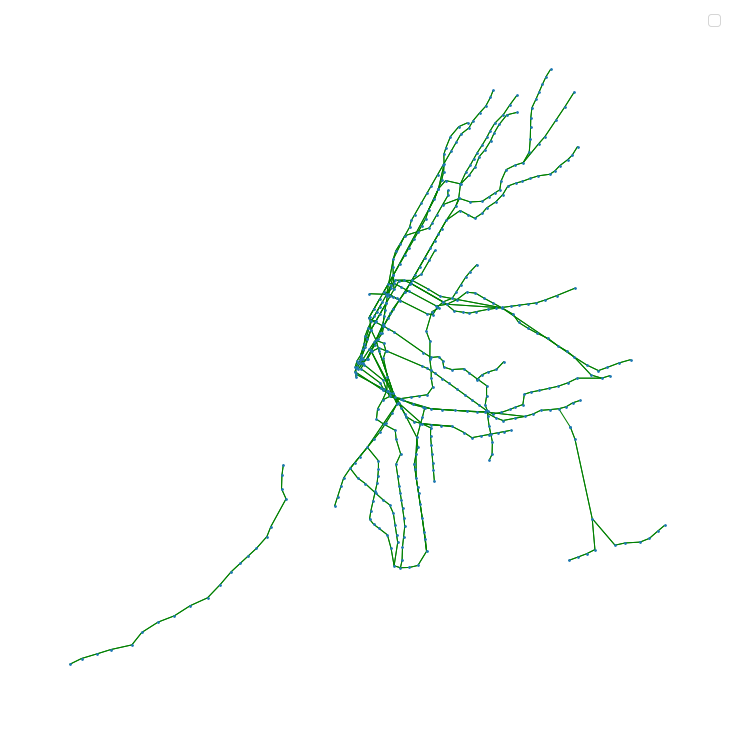

In [279]:
#visualize the subway newtork
plt.figure(figsize = (10,10))
nx.draw(NYCSubway,pos=StPos,with_labels=False,arrows=False,node_size=3,width=1,edge_color='green')
#plt.plot(subSample.long, subSample.lat, 'o', color='red', label='unknown ridership locations')
plt.legend(fontsize=15)

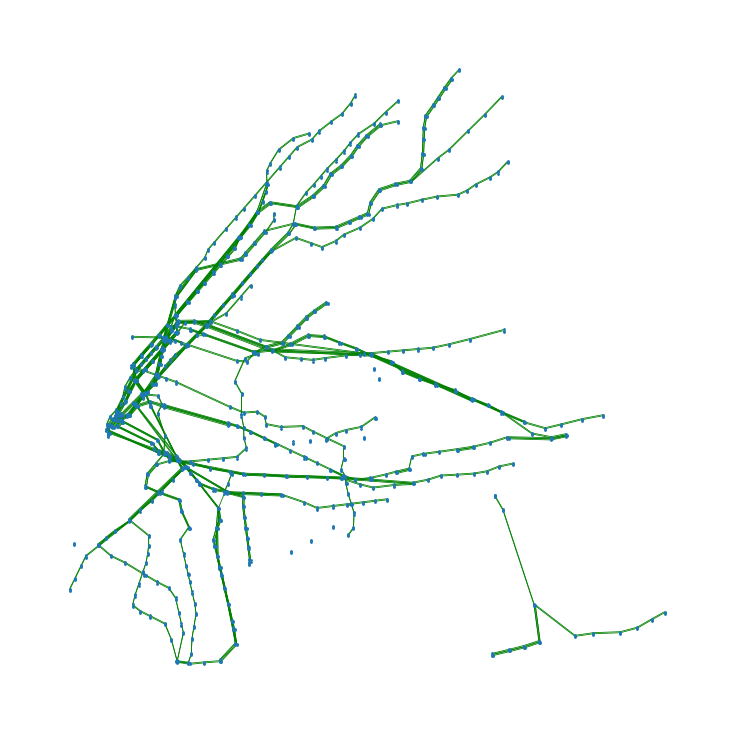

In [72]:
#visualize the subway newtork
plt.figure(figsize = (10,10))
nx.draw(uuNYCSubway,pos=nodePos,with_labels=False,arrows=False,node_size=3,width=0.8,edge_color='green')

In [73]:
nx.number_connected_components(uuNYCSubway)

14

In [74]:
for c in nx.connected_components(uuNYCSubway):
    if len(c) < 1000:
        print(c)
    

{'H01-A-S', 'H01', 'H01-A-N'}
{'H14-S-N', 'H13-A-S', 'H14', 'H14-A-N', 'H09-A-N', 'H13', 'H02-A-S', 'H13-A-N', 'H15-A-S', 'H10-A-N', 'H04-A-N', 'H11-A-N', 'H10', 'H02', 'H07', 'H06', 'H15-A-N', 'H08-A-N', 'H13-S-S', 'H15-S-S', 'H14-A-S', 'H11-A-S', 'H03-A-S', 'H12-A-S', 'H06-A-S', 'H03-A-N', 'H14-S-S', 'H12-S-N', 'H12-A-N', 'H15-S-N', 'H10-A-S', 'H07-A-N', 'H12-S-S', 'H08-A-S', 'H08', 'H02-A-N', 'H15', 'H12', 'H09-A-S', 'H13-S-N', 'H06-A-N', 'H07-A-S', 'H03', 'H04-A-S', 'H04-S-N', 'H04-S-S', 'H04', 'H09', 'H11'}
{'M09', 'M09-M-S', 'M09-M-N'}
{'M10', 'M10-M-S', 'M10-M-N'}
{'X1-IBX-S', 'X1-IBX-N', 'X1'}
{'X12-IBX-N', 'X12', 'X12-IBX-S'}
{'X14-IBX-N', 'X14', 'X14-IBX-S'}
{'X15-IBX-N', 'X15-IBX-S', 'X15'}
{'X16-IBX-N', 'X16', 'X16-IBX-S'}
{'X5-IBX-N', 'X5', 'X5-IBX-S'}
{'X6', 'X6-IBX-N', 'X6-IBX-S'}
{'X7-IBX-S', 'X7-IBX-N', 'X7'}
{'X8', 'X8-IBX-N', 'X8-IBX-S'}


In [35]:
neib = nx.single_source_shortest_path_length(NYCSubway, 'A41', cutoff=2)
list(neib.keys())

['A41',
 'A40',
 'F20',
 'R29',
 'A42',
 'F18',
 'G36',
 'A43',
 'F21',
 'A46',
 'A38',
 'R28',
 'F16',
 'R30']

#### Task 1a. Find shortest path between Jay Str.-Metrotech (A41) and Junction Blvd, Queens (707)

In [242]:
path1=nx.shortest_path(uuNYCSubway,'A41','707')
path2=nx.shortest_path(uuNYCSubway,'A40','F16')

In [243]:
path1

['A41',
 'A41-A-S',
 'A40-A-S',
 'A38-A-S',
 'A38',
 '418',
 '418-4-S',
 '640-4-S',
 '635-4-S',
 '631-4-S',
 '629-4-S',
 '629',
 'R11',
 'R11-R-S',
 'G21-R-S',
 'G14-R-S',
 'G14',
 '710',
 '710-7-S',
 '709-7-S',
 '708-7-S',
 '707-7-S',
 '707']

In [241]:
nodes[nodes['node_id']=='A38']

,station_id,station_line,lat,long,lines,boro,name,line_,dir,pf_id,node_id
1701,A38,station,40.710197,-74.007691,NaN,M,Fulton St,A C,station,station,A38


In [244]:
nodes[nodes['node_id']=='418']

,station_id,station_line,lat,long,lines,boro,name,line_,dir,pf_id,node_id
1764,418,station,40.710368,-74.009509,NaN,M,Fulton St,4 5,station,station,418


In [245]:
len(path1)

23

In [248]:
#auxiliary function - visualize path on the map
def visualize_path(path):
    plt.figure(figsize = (10,10))
    nx.draw(uuNYCSubway,pos=nodePos,with_labels=False,arrows=False,node_size=1,width=1,edge_color='green')
    x=[nodePos[v][0] for v in path]
    y=[nodePos[v][1] for v in path]
    plt.plot(x,y,'ro-')
    plt.plot([x[0],x[-1]],[y[0],y[-1]],'bs',markersize=10)

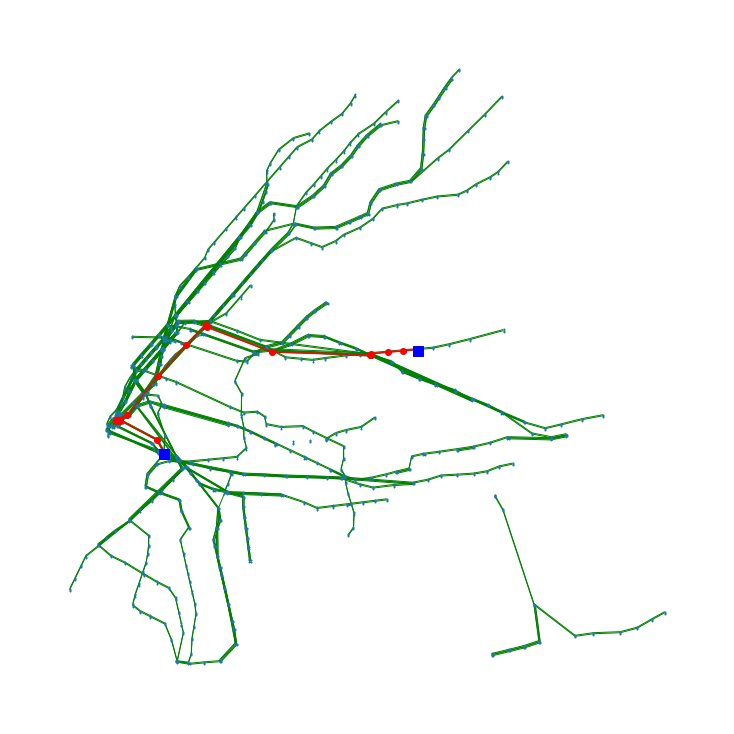

In [249]:
ax1 = visualize_path(path1)
#ax1 = visualize_path(path2)

#### Task 1b. Find shortest path between Jay Str.-Metrotech (A41) and Junction Blvd, Queens (707) in terms of travel distance 

In [390]:
#auxiliary function: geodesic distance on the Earth surface between two lat-long points
from math import sin, cos, sqrt, atan2, radians
def geodist(lon1,lat1,lon2,lat2):
    lat1 = radians(lat1)
    lon1 = radians(lon1)  
    lat2 = radians(lat2)
    lon2 = radians(lon2)
    R = 6373.0
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    return R * c

In [394]:
#compute and assing lengths the all the edges
nx.set_edge_attributes(uuNYCSubway, 'dist', 0)
for e in uuNYCSubway.edges():
   uuNYCSubway[e[0]][e[1]]['dist']=geodist(nodePos[e[0]][0],nodePos[e[0]][1],nodePos[e[1]][0],nodePos[e[1]][1])

In [395]:
path1=nx.shortest_path(uuNYCSubway,'A41','707',weight='dist') #shorest path according to dist

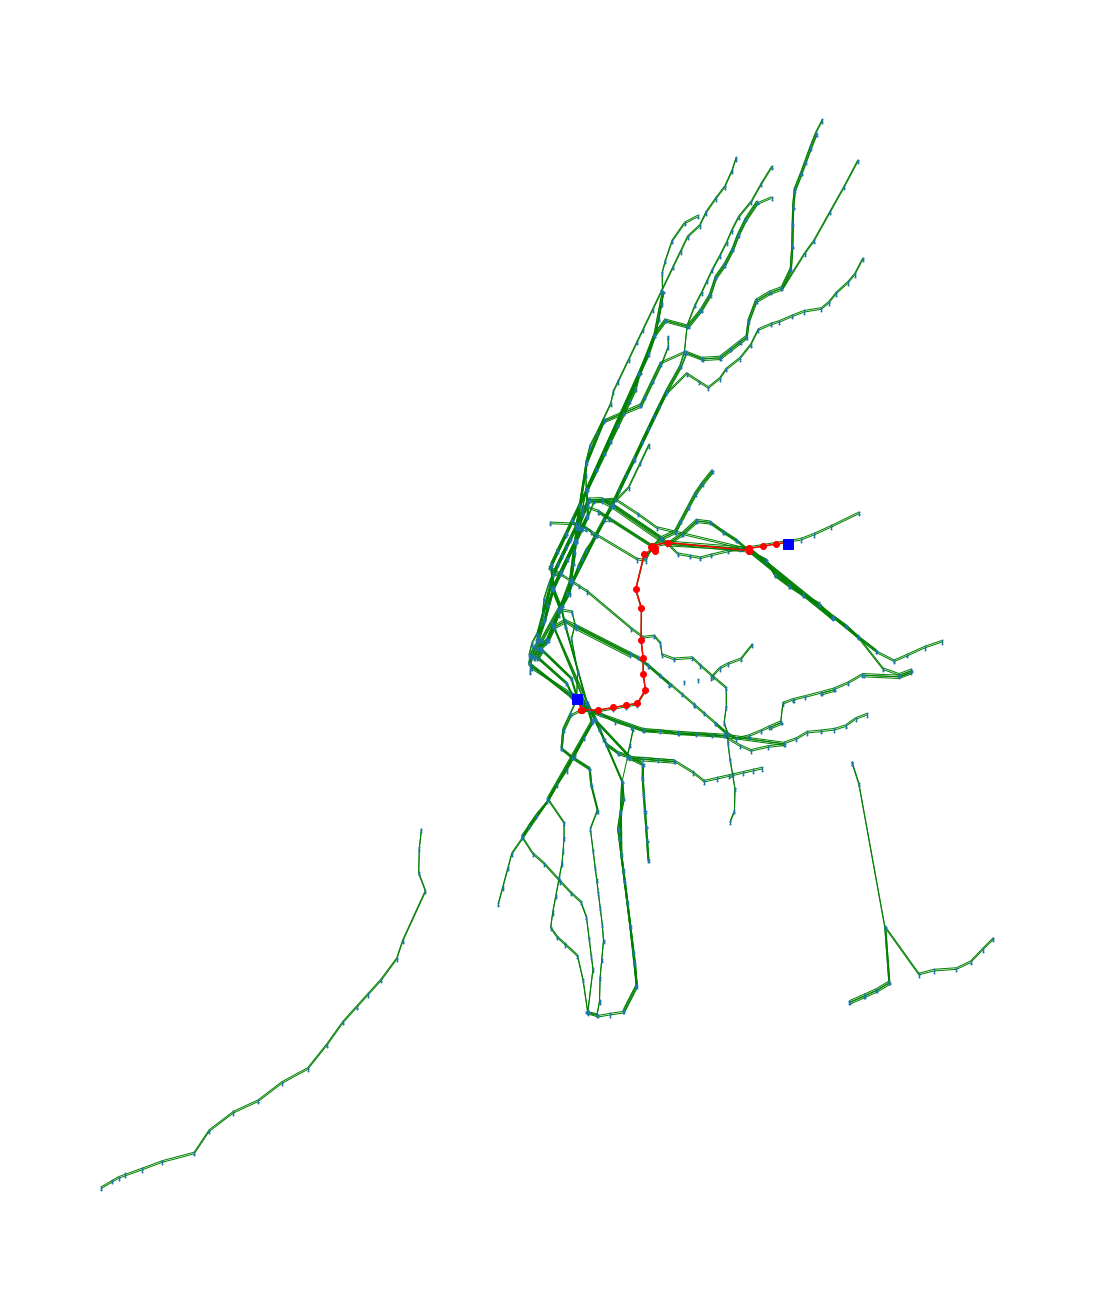

In [396]:
visualize_path(path1)